1. [**Исследование данных**](#preprocessing)
    * [**Знакомство с данными**](#meet)
        * [Пропущенные значения и нули](#omission)
        * [Типы данных](#tydedata)
    * [**Сводка по каждому пользователю**](#resume)
        * [Количество сделанных звонков и израсходованных минут разговора по месяцам](#minutes)
        * [Количество отправленных сообщений по месяцам](#messages)
        * [Объем израсходованного интернет-трафика по месяцам](#mb)
        * [Помесячная выручка с каждого пользователя](#revenue)
2. [**Анализ данных**](#analysis)
    * [**Активность пользователей каждого тарифа за месяц**](#activeness)
        * [Среднее количество, дисперсия и среднее отклонение](#meanvarstd)
            * [Тариф 'ultra'](#ultra)
            * [Тариф 'smart'](#smart)
        * [Гистограммы распределения](#histograms)
    * [**Гипотезы**](#hypothesis)
3. [**Выводы**](#summary)

<a id="preprocessing"></a>
# **Исследование данных**

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import calendar
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)

<a id="meet"></a>
## **Знакомство с данными**

In [3]:
users = pd.read_csv('../datasets/users.csv')
calls = pd.read_csv('../datasets/calls.csv')
messages = pd.read_csv('../datasets/messages.csv')
internet = pd.read_csv('../datasets/internet.csv')
tariffs = pd.read_csv('../datasets/tariffs.csv')

In [4]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
285,1285,44,NaN,Краснодар,Ефим,Амельченко,2018-02-20,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
321,1321,29,NaN,Москва,Онисим,Софронов,2018-02-04,smart
29,1029,51,NaN,Екатеринбург,Алексей,Селезнев,2018-09-15,smart


In [5]:
calls.sample(5)

,id,call_date,duration,user_id
108543,1280_462,2018-11-17,5.40,1280
30846,1078_190,2018-10-01,6.62,1078
128073,1329_153,2018-11-14,2.11,1329
54077,1135_370,2018-05-13,11.89,1135
164838,1408_87,2018-06-20,15.90,1408


In [6]:
messages.sample(5)

,id,message_date,user_id
35979,1155_368,2018-07-20,1155
58130,1256_214,2018-12-30,1256
110524,1447_209,2018-11-16,1447
106007,1430_82,2018-08-01,1430
99761,1409_62,2018-04-09,1409


In [7]:
internet.sample(5)

,id,mb_used,session_date,user_id
98676,1331_200,724.03,2018-07-22,1331
148721,1496_669,494.74,2018-06-23,1496
62732,1213_114,334.71,2018-09-16,1213
59720,1202_183,519.02,2018-12-18,1202
119450,1403_5,0.00,2018-08-21,1403


In [8]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [10]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [11]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [12]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [13]:
tariffs.describe()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


<a id="omission"></a>
### Пропущенные значения и нули

In [14]:
def isnull_percent(data, text):
    print ('Доля пропущенных значений '+text+':')
    return (data.isnull().sum() / data.shape[0]).apply('{:.2%}'.format)

In [15]:
isnull_percent(users, 'users')

Доля пропущенных значений users:


user_id        0.00%
age            0.00%
churn_date    92.40%
city           0.00%
first_name     0.00%
last_name      0.00%
reg_date       0.00%
tariff         0.00%
dtype: object

In [16]:
isnull_percent(calls, 'calls')

Доля пропущенных значений calls:


id           0.00%
call_date    0.00%
duration     0.00%
user_id      0.00%
dtype: object

In [17]:
isnull_percent(messages, 'messages')

Доля пропущенных значений messages:


id              0.00%
message_date    0.00%
user_id         0.00%
dtype: object

In [18]:
isnull_percent(internet, 'internet')

Доля пропущенных значений internet:


id              0.00%
mb_used         0.00%
session_date    0.00%
user_id         0.00%
dtype: object

In [19]:
isnull_percent(tariffs, 'tariffs')

Доля пропущенных значений tariffs:


messages_included        0.00%
mg_per_month_included    0.00%
minutes_included         0.00%
rub_monthly_fee          0.00%
rub_per_gb               0.00%
rub_per_message          0.00%
rub_per_minute           0.00%
tariff_name              0.00%
dtype: object

Пропущенные значения есть только **в таблице *users***. Но если значение пропущено, то тариф ещё действовал на момент выгрузки данных.  
**В таблице *calls*** встречаются звонки с нулевой длительностью. Скорее всего это те случаи, когда абонент не взял трубку.  
**В таблице *internet*** встречаются сессии с нулевым трафиком. Можно предположить, что человек потратил меньше мегабайта, но в этом случае округление шло бы в большую сторону.

In [20]:
print ('{:.2%} людей всё ещё пользуются тарифом'
       .format(users.query('churn_date.isnull()', engine='python')['user_id'].count() / users['user_id'].count()))
print ('{:.2%} звонков нулевой длительности'
       .format(calls.query('duration == 0')['duration'].count() / calls['duration'].count()))
print ('{:.2%} нулевых интернет-сессий'
       .format(internet.query('mb_used == 0')['mb_used'].count() / internet['mb_used'].count()))

92.40% людей всё ещё пользуются тарифом
19.55% звонков нулевой длительности
13.12% нулевых интернет-сессий


In [21]:
print (users.loc[users['churn_date'].notna(), 'churn_date'].max())
print (users.loc[users['reg_date'].notna(), 'reg_date'].max())
print (calls['call_date'].max())
print (messages['message_date'].max())
print (internet['session_date'].max())

2018-12-30
2018-12-31
2018-12-31
2018-12-31
2018-12-31


Неизвестные даты отключения тарифа можно заполнить 2018-12-31, так как во всей видимости выгрузка данных произошла в этот день - после него нет ни одного звонка, сообщения или интернет-сессии.  
Но лучше было бы уточнить, когда именно были выгружены данные.

In [22]:
users['churn_date'] = (
    users['churn_date']
    .where(users['churn_date'].notna(), '2018-12-31')
)

Можно предположить, что нулевые интернет-сессии это проверки подключения. Тогда для каждого user_id будет одна такая сессия при подключении тарифа.

In [23]:
print ('Количество уникальных пользователей:', len(internet['user_id'].unique()))
print ('Количество уникальных пользователей среди тех, у кого был нулевой трафик:',
       len(internet.query('mb_used == 0')['user_id'].unique()))

Количество уникальных пользователей: 497
Количество уникальных пользователей среди тех, у кого был нулевой трафик: 494


Существуют пользователи, у которых не было нулевых интернет-сессий.

Возможно, нулевые подключения возникали каждый месяц за просрочку оплаты.

In [24]:
internet.query('mb_used == 0').groupby('user_id').apply(lambda x: x.sort_values('session_date')).head(30)

id  mb_used session_date  user_id
user_id                                             
1000    103  1000_103      0.0   2018-05-26     1000
        72    1000_72      0.0   2018-06-15     1000
        131  1000_131      0.0   2018-06-15     1000
        67    1000_67      0.0   2018-06-16     1000
        193  1000_193      0.0   2018-06-17     1000
        46    1000_46      0.0   2018-06-30     1000
        157  1000_157      0.0   2018-07-11     1000
        201  1000_201      0.0   2018-08-21     1000
        11    1000_11      0.0   2018-08-28     1000
        111  1000_111      0.0   2018-09-01     1000
        191  1000_191      0.0   2018-09-17     1000
        38    1000_38      0.0   2018-11-27     1000
        165  1000_165      0.0   2018-12-21     1000
        143  1000_143      0.0   2018-12-29     1000
1001    303   1001_92      0.0   2018-11-02     1001
        227   1001_16      0.0   2018-11-14     1001
        248   1001_37      0.0   2018-11-14     1001
        302   1001_91      0.0   2018-11-14     1001
        272   1001_61      0.0   2018-11-18     1001
        297   1001_86      0.0   2018-11-19     1001
        243   1001_32      0.0   2018-11-25     1001
        274   1001_63      0.0   2018-11-29     1001
        261   1001_50      0.0   2018-12-05     1001
        279   1001_68      0.0   2018-12-07     1001
        217    1001_6      0.0   2018-12-08     1001
        231   1001_20      0.0   2018-12-13     1001
        219    1001_8      0.0   2018-12-18     1001
        263   1001_52      0.0   2018-12-29     1001
1002    550  1002_243      0.0   2018-06-22     1002
        463  1002_156      0.0   2018-06-24     1002

Существуют нулевые сессии в один и тот же день у одного и того же пользователя и нулевые сессии несколько дней подряд.

In [25]:
internet.groupby('user_id').apply(lambda x: x.sort_values('session_date')).head(30)

id  mb_used session_date  user_id
user_id                                             
1000    103  1000_103     0.00   2018-05-26     1000
        96    1000_96   544.22   2018-05-28     1000
        59    1000_59   363.20   2018-05-28     1000
        51    1000_51   628.41   2018-05-31     1000
        134  1000_134   717.66   2018-05-31     1000
        135  1000_135   517.36   2018-06-01     1000
        150  1000_150  1094.05   2018-06-01     1000
        17    1000_17   204.14   2018-06-03     1000
        37    1000_37   747.58   2018-06-03     1000
        162  1000_162   359.04   2018-06-05     1000
        173  1000_173   526.82   2018-06-06     1000
        126  1000_126   172.51   2018-06-06     1000
        122  1000_122   390.74   2018-06-06     1000
        206  1000_206  1028.22   2018-06-06     1000
        48    1000_48   210.52   2018-06-06     1000
        77    1000_77   283.62   2018-06-07     1000
        196  1000_196   814.42   2018-06-08     1000
        50    1000_50   277.96   2018-06-09     1000
        118  1000_118    27.53   2018-06-09     1000
        30    1000_30   577.19   2018-06-09     1000
        54    1000_54   272.46   2018-06-09     1000
        16    1000_16   459.28   2018-06-09     1000
        124  1000_124  1037.27   2018-06-10     1000
        137  1000_137   463.39   2018-06-13     1000
        113  1000_113   752.85   2018-06-14     1000
        131  1000_131     0.00   2018-06-15     1000
        72    1000_72     0.00   2018-06-15     1000
        116  1000_116   613.74   2018-06-16     1000
        67    1000_67     0.00   2018-06-16     1000
        198  1000_198   178.41   2018-06-17     1000

При этом между нулевыми сессиями в соседние дни могут быть и ненулевые.  
Так же даты нулевых сессий разных пользователей не совпадают, то есть это не связано с проблемами самого оператора.

Скорее всего человек подключился к интернету, но передумал не успев передать ни один пакет данных.

Посмотрим для какого из тарифов наибольшая доля недозвонившихся или невышедших в интернет.

In [26]:
# outer, чтобы не терять людей, которые в принципе не воспользовались звонками или интернетом
calls_tariff = pd.merge(users, calls, on = 'user_id', how = 'outer')
internet_tariff = pd.merge(users, internet, on = 'user_id', how = 'outer')

In [27]:
# добавим столбец, идентифицирующий нулевые звонки
# 0 - ноль минут
# 1 - больше нуля минут
calls_tariff['duration_0'] = (
    calls_tariff['duration']
    .where(calls_tariff['duration'] == 0, 1)
)
calls_tariff['duration_0'] = calls_tariff['duration_0'].astype(int)

In [28]:
# добавим столбец, идентифицирующий нулевые интернет-сессии
# 0 - ноль мегабайт
# 1 - больше нуля мегабайт
internet_tariff['mb_used_0'] = (
    internet_tariff['mb_used']
    .where(internet_tariff['mb_used'] == 0, 1)
)
internet_tariff['mb_used_0'] = internet_tariff['mb_used_0'].astype(int)

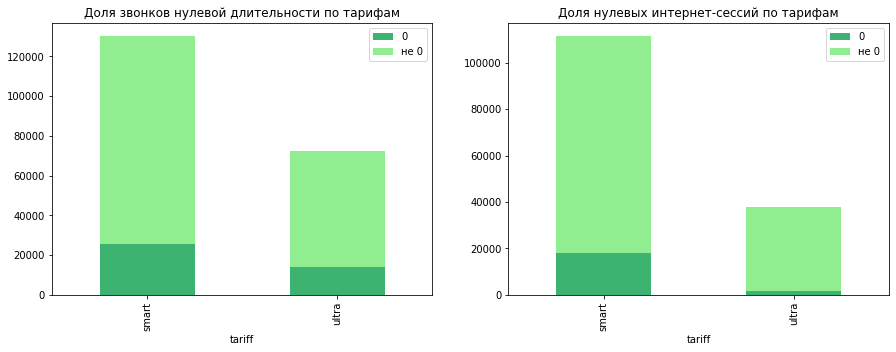

In [29]:
fig = plt.figure(figsize = (15, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

colors = ['#3CB371', '#90EE90']
ax1 = calls_tariff.groupby(['tariff', 'duration_0']).size().unstack().plot(kind = 'bar', stacked = True,
                                                                           color = colors, ax = ax1)
ax2 = internet_tariff.groupby(['tariff', 'mb_used_0']).size().unstack().plot(kind = 'bar', stacked = True,
                                                                             color = colors, ax = ax2)

ax1.set_title('Доля звонков нулевой длительности по тарифам')
ax2.set_title('Доля нулевых интернет-сессий по тарифам')

ax1.legend(['0', 'не 0'], loc = 1)
ax2.legend(['0', 'не 0'], loc = 1)

plt.savefig('images/zero.png')
plt.show()

In [30]:
print ('{:.2%} нулевых звонков при тарифе smart'
       .format(calls_tariff.query('duration_0 == 0 and tariff == "smart"')['user_id'].count() /
               calls_tariff.query('tariff == "smart"')['user_id'].count()))
print ('{:.2%} нулевых звонков при тарифе ultra'
       .format(calls_tariff.query('duration_0 == 0 and tariff == "ultra"')['user_id'].count() /
               calls_tariff.query('tariff == "ultra"')['user_id'].count()))
print ('{:.2%} нулевых интернет-сессий при тарифе smart'
       .format(internet_tariff.query('mb_used_0 == 0 and tariff == "smart"')['user_id'].count() /
               internet_tariff.query('tariff == "smart"')['user_id'].count()))
print ('{:.2%} нулевых интернет-сессий при тарифе ultra'
       .format(internet_tariff.query('mb_used_0 == 0 and tariff == "ultra"')['user_id'].count() /
               internet_tariff.query('tariff == "ultra"')['user_id'].count()))

19.70% нулевых звонков при тарифе smart
19.29% нулевых звонков при тарифе ultra
15.98% нулевых интернет-сессий при тарифе smart
4.69% нулевых интернет-сессий при тарифе ultra


Нулевая длительность звонка, как и нулевой трафик, говорят о том, что пользователь уже был подключён к тарифу, поэтому не будем их удалять.

Округление до целых минут

In [31]:
calls['duration'] = np.ceil(calls['duration'])

<a id="tydedata"></a>
### Типы данных

In [32]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [33]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [34]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [35]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [36]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Преобразуем даты в формат даты

In [37]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

Длительность звонков можно преобразовать в целые числа.  
А интернет-трафик пока оставим как есть.

In [38]:
calls['duration'] = calls['duration'].astype(int)

<a id="resume"></a>
## **Сводка по каждому пользователю**

Обычно, когда человек подключает тариф, он начинает действовать сразу. То есть, если человек подключился 26.08.2018, а отключился 21.11.2018, то он пользовался тарифом 3 месяца: 26.08 - 25.09, 26.09 - 25.10 и 26.10 - 21.11.  
В этом случае месяц 26.08 - 25.09 считается за календарный август по дате оплаты. Тогда получается, что в календарном ноябре он этим тарифом уже не пользовался.

Такой рассчет позволит более реально оценить насколько каждому человеку подходит данный тариф: будет понятно, сколько минут, сообщений и трафика он тратит за месяц, за который платит абонентскую плату.

Но для оператора так же интересно видеть, в какие месяцы люди больше звонят, а в какие больше сидят в интернете, чтобы предполагать загруженность сети.

Наша задача выяснить, какой тариф лучше, поэтому будем считать, что в данном примере все звонки, совершённые с 26.08 по 25.09, сделаны в августе.

In [39]:
def merge_pivot_month(action_data, column_date, column_value, func):
    month_name = dict((k,v) for k,v in enumerate(calendar.month_abbr))
    temp_data = pd.merge(users, action_data, on = 'user_id', how = 'outer')
    temp_data['month'] = (
        temp_data[column_date].dt.month
        .where(temp_data[column_date].dt.day >= temp_data['reg_date'].dt.day, temp_data[column_date].dt.month - 1)
    )
    new_data = (
    temp_data
    .pivot_table(index = ['user_id', 'tariff', 'reg_date', 'churn_date'], columns = 'month',
                 values = column_value, aggfunc = func)
    )
    new_data.columns = new_data.columns.astype(int).map(month_name)
    new_data.reset_index(inplace = True)
    new_data['month'] = np.round(new_data.loc[:, 'Jan':'Dec'].mean(axis = 1), 2)
    new_data['month'] = new_data['month'].fillna(0)
    new_data = new_data.sort_values('user_id')
    return new_data

Месяцы, когда пользователь ещё не был подключён, останутся не заполненными для последующей обработки.

<a id="minutes"></a>
<div class="alert alert-block alert-info">

### Количество сделанных звонков и израсходованных минут разговора по месяцам

</div>

In [40]:
calls_user_num = merge_pivot_month(calls, 'call_date', 'duration', len)
print ('mean:', np.round(calls_user_num['month'].mean(), 2))
print ('smart:', np.round(calls_user_num.query('tariff == "smart"')['month'].mean(), 2))
print ('ultra:', np.round(calls_user_num.query('tariff == "ultra"')['month'].mean(), 2))
calls_user_num.head(3)

mean: 64.34
smart: 59.14
ultra: 77.01


month,user_id,tariff,reg_date,churn_date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,month
0,1000,ultra,2018-05-25,2018-12-31,NaN,NaN,NaN,NaN,54.0,46.0,54.0,55.0,55.0,50.0,48.0,6.0,46.0
1,1001,smart,2018-11-01,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,61.0
2,1002,smart,2018-06-17,2018-12-31,NaN,NaN,NaN,NaN,NaN,28.0,34.0,40.0,30.0,36.0,34.0,15.0,31.0


In [41]:
calls_user_sum = merge_pivot_month(calls, 'call_date', 'duration', np.sum)
print ('mean:', np.round(calls_user_sum['month'].mean(), 2))
print ('smart:', np.round(calls_user_sum.query('tariff == "smart"')['month'].mean(), 2))
print ('ultra:', np.round(calls_user_sum.query('tariff == "ultra"')['month'].mean(), 2))
calls_user_sum.head(3)

mean: 461.11
smart: 423.24
ultra: 553.54


month,user_id,tariff,reg_date,churn_date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,month
0,1000,ultra,2018-05-25,2018-12-31,NaN,NaN,NaN,NaN,299.0,284.0,403.0,482.0,368.0,341.0,340.0,49.0,320.75
1,1001,smart,2018-11-01,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,422.00
2,1002,smart,2018-06-17,2018-12-31,NaN,NaN,NaN,NaN,NaN,220.0,262.0,227.0,191.0,219.0,300.0,98.0,216.71


<a id="messages"></a>
<div class="alert alert-block alert-info">

### Количество отправленных сообщений по месяцам

</div>

In [42]:
messages_users_num = merge_pivot_month(messages, 'message_date', 'id', len)
print ('mean:', np.round(messages_users_num['month'].mean(), 2))
print ('smart:', np.round(messages_users_num.query('tariff == "smart"')['month'].mean(), 2))
print ('ultra:', np.round(messages_users_num.query('tariff == "ultra"')['month'].mean(), 2))
messages_users_num.head(3)

mean: 45.69
smart: 37.71
ultra: 65.11


month,user_id,tariff,reg_date,churn_date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,month
0,1000,ultra,2018-05-25,2018-12-31,NaN,NaN,NaN,NaN,63.0,70.0,81.0,74.0,56.0,70.0,69.0,13.0,62.0
1,1002,smart,2018-06-17,2018-12-31,NaN,NaN,NaN,NaN,NaN,8.0,14.0,8.0,6.0,13.0,17.0,4.0,10.0
2,1003,ultra,2018-08-17,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,95.0,85.0,82.0,37.0,76.0


<a id="mb"></a>
<div class="alert alert-block alert-info">

### Объем израсходованного интернет-трафика по месяцам

</div>

In [43]:
internet_users = merge_pivot_month(internet, 'session_date', 'mb_used', np.sum)
print ('mean:', np.round(internet_users['month'].mean(), 2))
print ('smart:', np.round(internet_users.query('tariff == "smart"')['month'].mean(), 2))
print ('ultra:', np.round(internet_users.query('tariff == "ultra"')['month'].mean(), 2))
internet_users.head(3)

mean: 17355.29
smart: 16252.89
ultra: 19980.05


month,user_id,tariff,reg_date,churn_date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,month
0,1000,ultra,2018-05-25,2018-12-31,NaN,NaN,NaN,NaN,17821.04,18727.60,11440.52,17144.44,15712.70,15498.21,8649.20,2398.60,13424.04
1,1001,smart,2018-11-01,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,16233.00
2,1002,smart,2018-06-17,2018-12-31,NaN,NaN,NaN,NaN,NaN,19275.09,16909.50,21135.63,12799.53,18231.34,17650.72,10034.71,16576.65


<a id="revenue"></a>
<div class="alert alert-block alert-info">

### Помесячная выручка с каждого пользователя

</div>

In [44]:
def swap(data, n, column):
    exile = data[column]
    data.drop(labels = [column], axis = 1, inplace = True)
    data.insert(n, column, exile)

In [45]:
# Собираем вместе длительность звонков, количество сообщений и интернет-трафик по месяцам
# с параметрами тарифов
all_num_users = pd.merge(calls_user_sum, messages_users_num, on = ('user_id', 'tariff', 'reg_date', 'churn_date'),
                         how = 'outer', suffixes = ('_call', '_mess'))
all_num_users = pd.merge(all_num_users, internet_users, on = ('user_id', 'tariff', 'reg_date', 'churn_date'),
                         how = 'outer')
all_num_users = pd.merge(all_num_users, tariffs, left_on = ('tariff'), right_on = ('tariff_name'),
                         how = 'outer')
all_num_users = pd.merge(all_num_users, calls_user_num, on = ('user_id', 'tariff', 'reg_date', 'churn_date'),
                         how = 'outer')

swap(all_num_users, 4, 'month_call')
swap(all_num_users, 5, 'month_y')
swap(all_num_users, 6, 'month_mess')
swap(all_num_users, 7, 'month_x')


all_num_users = all_num_users.sort_values('user_id')
all_num_users.head(5)

,user_id,tariff,reg_date,churn_date,month_call,month_y,month_mess,month_x,Jan_call,Feb_call,Mar_call,Apr_call,May_call,Jun_call,Jul_call,Aug_call,Sep_call,Oct_call,Nov_call,Dec_call,Jan_mess,Feb_mess,Mar_mess,Apr_mess,May_mess,Jun_mess,Jul_mess,Aug_mess,Sep_mess,Oct_mess,Nov_mess,Dec_mess,Jan_x,Feb_x,Mar_x,Apr_x,May_x,Jun_x,Jul_x,Aug_x,Sep_x,Oct_x,Nov_x,Dec_x,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,Jan_y,Feb_y,Mar_y,Apr_y,May_y,Jun_y,Jul_y,Aug_y,Sep_y,Oct_y,Nov_y,Dec_y
0,1000,ultra,2018-05-25,2018-12-31,320.75,46.0,62.0,13424.04,NaN,NaN,NaN,NaN,299.0,284.0,403.0,482.0,368.0,341.0,340.0,49.0,NaN,NaN,NaN,NaN,63.0,70.0,81.0,74.0,56.0,70.0,69.0,13.0,NaN,NaN,NaN,NaN,17821.04,18727.60,11440.52,17144.44,15712.70,15498.21,8649.20,2398.60,1000,30720,3000,1950,150,1,1,ultra,NaN,NaN,NaN,NaN,54.0,46.0,54.0,55.0,55.0,50.0,48.0,6.0
148,1001,smart,2018-11-01,2018-12-31,422.00,61.0,NaN,16233.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,50,15360,500,550,200,3,3,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
149,1002,smart,2018-06-17,2018-12-31,216.71,31.0,10.0,16576.65,NaN,NaN,NaN,NaN,NaN,220.0,262.0,227.0,191.0,219.0,300.0,98.0,NaN,NaN,NaN,NaN,NaN,8.0,14.0,8.0,6.0,13.0,17.0,4.0,NaN,NaN,NaN,NaN,NaN,19275.09,16909.50,21135.63,12799.53,18231.34,17650.72,10034.71,50,15360,500,550,200,3,3,smart,NaN,NaN,NaN,NaN,NaN,28.0,34.0,40.0,30.0,36.0,34.0,15.0
1,1003,ultra,2018-08-17,2018-12-31,764.40,104.0,76.0,11456.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938.0,851.0,806.0,922.0,305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,95.0,85.0,82.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11958.23,16425.59,16102.61,6814.97,5979.24,1000,30720,3000,1950,150,1,1,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,108.0,107.0,119.0,51.0
2,1004,ultra,2018-05-14,2018-12-31,123.38,22.0,149.0,18629.94,NaN,NaN,NaN,NaN,92.0,154.0,141.0,151.0,102.0,176.0,58.0,113.0,NaN,NaN,NaN,NaN,154.0,155.0,163.0,160.0,141.0,165.0,170.0,84.0,NaN,NaN,NaN,NaN,20602.05,19906.94,25339.45,22305.11,19145.23,15105.69,15957.65,10677.36,1000,30720,3000,1950,150,1,1,ultra,NaN,NaN,NaN,NaN,21.0,27.0,20.0,26.0,22.0,32.0,13.0,15.0


In [46]:
# определяет месяц окончания пользования тарифом
def month_end(start_date, end_date):
    if end_date.day >= start_date.day:
        return end_date.month
    else:
        return end_date.month - 1

In [47]:
all_num_users['month_last_pay'] = all_num_users.apply(lambda x : month_end(x['reg_date'], x['churn_date']), axis = 1)

In [48]:
# записывает значение месячной выручки по значениям звонков, сообщений и трафика в этот месяц
def month_price(column_call, column_ncal, column_mess, column_inet, number_month):
    start = all_num_users['reg_date'].dt.month
    end = all_num_users['month_last_pay']
    month = number_month + 1

# в следующих 4 строках получится 1, если числитель больше знаменателя, и NaN, если нет
    fee = ((month // start) // (month // start)) * ((end // month) // (end // month))
    minute = (all_num_users[column_call] // all_num_users['minutes_included']) * (all_num_users[column_call] // all_num_users['minutes_included'])
    message = (all_num_users[column_mess] // all_num_users['messages_included']) * (all_num_users[column_mess] // all_num_users['messages_included'])
    mg = (all_num_users[column_inet] // all_num_users['mg_per_month_included']) * (all_num_users[column_inet] // all_num_users['mg_per_month_included'])

    fee = fee.fillna(0)
    minute = minute.fillna(0)
    message = message.fillna(0)
    mg = mg.fillna(0)

# если тариф подключён, но активности не было - записать 0
    all_num_users[column_call] = all_num_users[column_call].where(fee == 0, all_num_users[column_call].fillna(0))
    all_num_users[column_mess] = all_num_users[column_mess].where(fee == 0, all_num_users[column_mess].fillna(0))
    all_num_users[column_inet] = all_num_users[column_inet].where(fee == 0, all_num_users[column_inet].fillna(0))
    all_num_users[column_ncal] = all_num_users[column_ncal].where(fee == 0, all_num_users[column_ncal].fillna(0))

    price = (
        (all_num_users[column_call] - all_num_users['minutes_included']) * minute *
        all_num_users['rub_per_minute'] +
        (all_num_users[column_mess] - all_num_users['messages_included']) * message *
        all_num_users['rub_per_message'] +
        np.ceil((all_num_users[column_inet] - all_num_users['mg_per_month_included']) * mg / 1024) *
        all_num_users['rub_per_gb'] +
        fee * all_num_users['rub_monthly_fee']
    )
    
    all_num_users['month_call'] = all_num_users['month_call'].where(fee == 0, all_num_users['month_call'].fillna(0))
    all_num_users['month_mess'] = all_num_users['month_mess'].where(fee == 0, all_num_users['month_mess'].fillna(0))
    all_num_users['month_x'] = all_num_users['month_x'].where(fee == 0, all_num_users['month_x'].fillna(0))
    all_num_users['month_y'] = all_num_users['month_y'].where(fee == 0, all_num_users['month_y'].fillna(0))
    
    #price = price.astype(int)
    return price

In [49]:
# названия столбцов: новых с выручкой, длительность звонков, количество сообщений и интернет-трафик по месяцам
month_price_name = ['Jan_price', 'Feb_price', 'Mar_price', 'Apr_price', 'May_price', 'Jun_price',
                    'Jul_price', 'Aug_price', 'Sep_price', 'Oct_price', 'Nov_price', 'Dec_price']
month_call_name = ['Jan_call', 'Feb_call', 'Mar_call', 'Apr_call', 'May_call', 'Jun_call',
                    'Jul_call', 'Aug_call', 'Sep_call', 'Oct_call', 'Nov_call', 'Dec_call']
month_mess_name = ['Jan_mess', 'Feb_mess', 'Mar_mess', 'Apr_mess', 'May_mess', 'Jun_mess',
                   'Jul_mess', 'Aug_mess', 'Sep_mess', 'Oct_mess', 'Nov_mess', 'Dec_mess']
month_inet_name = ['Jan_x', 'Feb_x', 'Mar_x', 'Apr_x', 'May_x', 'Jun_x', 'Jul_x',
                   'Aug_x', 'Sep_x', 'Oct_x', 'Nov_x', 'Dec_x']
month_ncalls_name = ['Jan_y', 'Feb_y', 'Mar_y', 'Apr_y', 'May_y', 'Jun_y', 'Jul_y',
                     'Aug_y', 'Sep_y', 'Oct_y', 'Nov_y', 'Dec_y']

# создаём ноые столбцы
for i in range(12):
    all_num_users[month_price_name[i]] = 0
    
for i in range(12):
    all_num_users[month_price_name[i]] = month_price(month_call_name[i], month_ncalls_name[i],
                                                     month_mess_name[i], month_inet_name[i], i)
    
all_num_users['month_price'] = np.round(all_num_users.loc[:, 'Jan_price':'Dec_price'].mean(axis = 1), 2)
swap(all_num_users, 8, 'month_price')
all_num_users = all_num_users.rename({'month_call': 'mean_call',
                                      'month_y': 'mean_ncall',
                                      'month_mess': 'mean_mess',
                                      'month_x': 'mean_inet',
                                      'month_price': 'mean_price'}, axis = 1)

all_num_users.head(3)

,user_id,tariff,reg_date,churn_date,mean_call,mean_ncall,mean_mess,mean_inet,mean_price,Jan_call,Feb_call,Mar_call,Apr_call,May_call,Jun_call,Jul_call,Aug_call,Sep_call,Oct_call,Nov_call,Dec_call,Jan_mess,Feb_mess,Mar_mess,Apr_mess,May_mess,Jun_mess,Jul_mess,Aug_mess,Sep_mess,Oct_mess,Nov_mess,Dec_mess,Jan_x,Feb_x,Mar_x,Apr_x,May_x,Jun_x,Jul_x,Aug_x,Sep_x,Oct_x,Nov_x,Dec_x,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,Jan_y,Feb_y,Mar_y,Apr_y,May_y,Jun_y,Jul_y,Aug_y,Sep_y,Oct_y,Nov_y,Dec_y,month_last_pay,Jan_price,Feb_price,Mar_price,Apr_price,May_price,Jun_price,Jul_price,Aug_price,Sep_price,Oct_price,Nov_price,Dec_price
0,1000,ultra,2018-05-25,2018-12-31,320.75,46.0,62.0,13424.04,1950.00,NaN,NaN,NaN,NaN,299.0,284.0,403.0,482.0,368.0,341.0,340.0,49.0,NaN,NaN,NaN,NaN,63.0,70.0,81.0,74.0,56.0,70.0,69.0,13.0,NaN,NaN,NaN,NaN,17821.04,18727.60,11440.52,17144.44,15712.70,15498.21,8649.20,2398.60,1000,30720,3000,1950,150,1,1,ultra,NaN,NaN,NaN,NaN,54.0,46.0,54.0,55.0,55.0,50.0,48.0,6.0,12,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
148,1001,smart,2018-11-01,2018-12-31,422.00,61.0,0.0,16233.00,850.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,50,15360,500,550,200,3,3,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
149,1002,smart,2018-06-17,2018-12-31,216.71,31.0,10.0,16576.65,1064.29,NaN,NaN,NaN,NaN,NaN,220.0,262.0,227.0,191.0,219.0,300.0,98.0,NaN,NaN,NaN,NaN,NaN,8.0,14.0,8.0,6.0,13.0,17.0,4.0,NaN,NaN,NaN,NaN,NaN,19275.09,16909.50,21135.63,12799.53,18231.34,17650.72,10034.71,50,15360,500,550,200,3,3,smart,NaN,NaN,NaN,NaN,NaN,28.0,34.0,40.0,30.0,36.0,34.0,15.0,12,NaN,NaN,NaN,NaN,NaN,1350.0,950.0,1750.0,550.0,1150.0,1150.0,550.0


Сформируем таблицу, где оставим только помесячную выручку и среднее в месяц по каждому параметру

In [50]:
def query_activ(cols, col):
    tariffs_columns = ['messages_included', 'mg_per_month_included', 'minutes_included',
                   'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name']
    cols_month = [month_price_name, month_call_name, month_mess_name, month_inet_name, month_ncalls_name]
    cols_mean = ['mean_call', 'mean_ncall', 'mean_mess', 'mean_inet', 'mean_price']
    
    cols_month.remove(cols)
    cols_mean.remove(col)
    
    data = all_num_users.copy()
    
    del data[cols_mean[0]]
    del data[cols_mean[1]]
    del data[cols_mean[2]]
    del data[cols_mean[3]]
    
    for i in range(12):
        del data[cols_month[0][i]]
        del data[cols_month[1][i]]
        del data[cols_month[2][i]]
        del data[cols_month[3][i]]

    for column in tariffs_columns:
        del data[column]

    del data['month_last_pay']

    data.columns = ['user_id', 'tariff', 'reg_date', 'churn_date', col,
                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return data

In [51]:
users_gain = query_activ(month_price_name, 'mean_price')
print ('mean:', np.round(users_gain['mean_price'].mean(), 2))
print ('smart:', np.round(users_gain.query('tariff == "smart"')['mean_price'].mean(), 2))
print ('ultra:', np.round(users_gain.query('tariff == "ultra"')['mean_price'].mean(), 2))
users_gain.head(3)

mean: 1644.46
smart: 1456.33
ultra: 2089.37


,user_id,tariff,reg_date,churn_date,mean_price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1000,ultra,2018-05-25,2018-12-31,1950.00,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
148,1001,smart,2018-11-01,2018-12-31,850.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1150.0,550.0
149,1002,smart,2018-06-17,2018-12-31,1064.29,NaN,NaN,NaN,NaN,NaN,1350.0,950.0,1750.0,550.0,1150.0,1150.0,550.0


<a id="analysis"></a>
# **Анализ данных**

<a id="activeness"></a>
## **Активность пользователей каждого тарифа за месяц**

Сформируем таблицы по каждому виду активности с учётом пользователей, которые не совершали звонки или не отправляли сообщений или не пользовались интернетом.

In [52]:
users_calls_num = query_activ(month_ncalls_name, 'mean_ncall')
users_calls_num.head(3)

,user_id,tariff,reg_date,churn_date,mean_ncall,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1000,ultra,2018-05-25,2018-12-31,46.0,NaN,NaN,NaN,NaN,54.0,46.0,54.0,55.0,55.0,50.0,48.0,6.0
148,1001,smart,2018-11-01,2018-12-31,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
149,1002,smart,2018-06-17,2018-12-31,31.0,NaN,NaN,NaN,NaN,NaN,28.0,34.0,40.0,30.0,36.0,34.0,15.0


In [53]:
users_calls_sum = query_activ(month_call_name, 'mean_call')
users_calls_sum.head(3)

,user_id,tariff,reg_date,churn_date,mean_call,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1000,ultra,2018-05-25,2018-12-31,320.75,NaN,NaN,NaN,NaN,299.0,284.0,403.0,482.0,368.0,341.0,340.0,49.0
148,1001,smart,2018-11-01,2018-12-31,422.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
149,1002,smart,2018-06-17,2018-12-31,216.71,NaN,NaN,NaN,NaN,NaN,220.0,262.0,227.0,191.0,219.0,300.0,98.0


In [54]:
users_messages = query_activ(month_mess_name, 'mean_mess')
users_messages.head(3)

,user_id,tariff,reg_date,churn_date,mean_mess,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1000,ultra,2018-05-25,2018-12-31,62.0,NaN,NaN,NaN,NaN,63.0,70.0,81.0,74.0,56.0,70.0,69.0,13.0
148,1001,smart,2018-11-01,2018-12-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
149,1002,smart,2018-06-17,2018-12-31,10.0,NaN,NaN,NaN,NaN,NaN,8.0,14.0,8.0,6.0,13.0,17.0,4.0


In [55]:
users_inet = query_activ(month_inet_name, 'mean_inet')
users_inet.head(3)

,user_id,tariff,reg_date,churn_date,mean_inet,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1000,ultra,2018-05-25,2018-12-31,13424.04,NaN,NaN,NaN,NaN,17821.04,18727.60,11440.52,17144.44,15712.70,15498.21,8649.20,2398.60
148,1001,smart,2018-11-01,2018-12-31,16233.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
149,1002,smart,2018-06-17,2018-12-31,16576.65,NaN,NaN,NaN,NaN,NaN,19275.09,16909.50,21135.63,12799.53,18231.34,17650.72,10034.71


<a id="meanvarstd"></a>
### Среднее количество, дисперсия и среднее отклонение

In [56]:
def color_column(s, col):
    return ['background-color: #67E0D4' if s.name == col else '' for v in s.index]

In [57]:
def mean_var_std(data, tariff, limit):
    cols = dict((k,v) for k,v in enumerate(calendar.month_abbr))
    del cols[0]
    temp_data = pd.DataFrame()
    for x in cols.values():
        temp_data.loc['users', x] = len(data.loc[data[x].notna()].query('tariff == @@tariff')['user_id'].unique())
        temp_data.loc['sum', x] = np.round(data.loc[data[x].notna()].query('tariff == @@tariff')[x].sum(), 2)
        temp_data.loc['mean', x] = np.round(data.loc[data[x].notna()].query('tariff == @@tariff')[x].mean(), 2)
        temp_data.loc['var', x] = np.round(data.loc[data[x].notna()].query('tariff == @@tariff')[x].var(), 2)
        temp_data.loc['std', x] = np.round(data.loc[data[x].notna()].query('tariff == @@tariff')[x].std(), 2)
    
    temp_data.loc['users', 'per_month'] = np.round(temp_data.loc['users', 'Jan':'Dec'].mean())
    temp_data.loc['sum', 'per_month'] = tariffs.query('tariff_name == @@tariff')[limit].mean()
    temp_data.loc['mean', 'per_month'] = np.round(temp_data.loc['sum', 'Jan':'Dec'].mean())
    temp_data.loc['var', 'per_month'] = np.round(temp_data.loc['sum', 'Jan':'Dec'].var())
    temp_data.loc['std', 'per_month'] = np.round(temp_data.loc['sum', 'Jan':'Dec'].std())

    return temp_data

<span style="color:cadetblue">
    
*В столбец **per_month** записываются следующие данные:*
- **users**: *количество пользователей в месяц в среднем*
- **sum**: *предел параметра активности из тарифного плана*
- **mean**: *среднее в месяц по всем пользователям тарифа*
- **var**: *дисперсия по всем пользователям тарифа*
- **std**: *стандартное отклонение по всем пользователям тарифа*

</span>

In [58]:
def box_activ(data_activ, tariff, limit_act):
    cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    color_mean = '#30BA8F'
    color_median = '#D76E00'

    flierprops = dict(marker = '+', markeredgecolor = 'b')
    meanpointprops = dict(marker = '.', markeredgecolor = color_mean, markerfacecolor = color_mean)
    medianprops = dict(linestyle = '-', linewidth = 1)

    data = mean_var_std(data_activ, tariff, limit_act)

    fig, ax = plt.subplots(figsize = (15, 10), sharey = True)

    mn = data.loc['mean', 'Jan':'Dec'].T.reset_index().plot(color = color_mean, linewidth = 1,
                                                            grid = True, linestyle = '--', figsize = (15, 10),
                                                            legend = True, label = 'mean', ax = ax)
    mn.set_xlim(-1, 12)
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], cols)

    limit = data.loc['sum', 'per_month']
    plt.axhline(y = limit, color = 'r', linestyle = '-.', label = 'limit')

    bp = data_activ.query('tariff == @tariff').boxplot(column = cols, medianprops = medianprops,
                                meanprops = meanpointprops, showmeans = True, return_type = 'dict',
                                flierprops = flierprops,
                                positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    [item.set_color(color_median) for item in bp['medians']]
    
    ax.legend(bbox_to_anchor = (1.12, 0.95), fontsize = 12)

    plt.savefig('images/'+str(tariff)+'_'+str(limit_act)+'.png')
    return plt.show()

<a id="ultra"></a>
#### Тариф 'ultra'

In [59]:
print ('Количество минут')
mean_var_std(users_calls_sum, 'ultra', 'minutes_included').style.apply(color_column, col = 'per_month')

Количество минут


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,9,24,37,55,67,84,91,107,114,120,133,135,81
sum,5813,12193,21409,30814,37803,44630,51968,60887,63804,70175,76154,43074,3000
mean,645.89,508.04,578.62,560.25,564.22,531.31,571.08,569.04,559.68,584.79,572.59,319.07,43227
var,70694.1,100434,69200.2,56628.3,90528.6,86286.6,94097.1,99699.6,98289.6,104461,104708,76084,5.13319e+08
std,265.88,316.91,263.06,237.97,300.88,293.75,306.75,315.75,313.51,323.2,323.59,275.83,22657


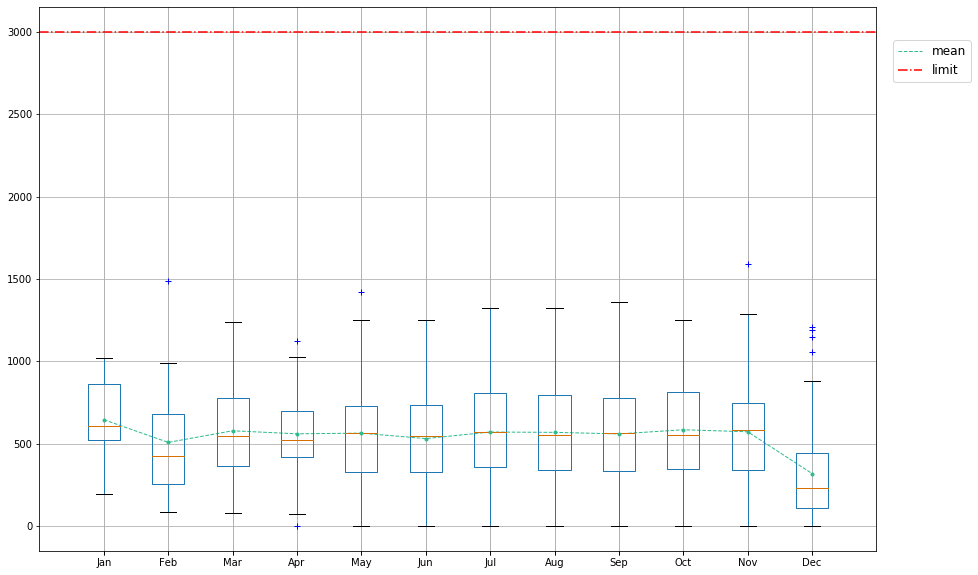

In [60]:
box_activ(users_calls_sum, 'ultra', 'minutes_included')

In [61]:
print ('Количество сообщений')
mean_var_std(users_messages, 'ultra', 'messages_included').style.apply(color_column, col = 'per_month')

Количество сообщений


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,9,24,37,55,67,84,91,107,114,120,133,135,81
sum,430,922,1387,2101,3151,4066,4655,5971,6369,7213,7693,4665,1000
mean,47.78,38.42,37.49,38.2,47.03,48.4,51.15,55.8,55.87,60.11,57.84,34.56,4052
var,1582.69,1861.82,1605.81,1659.16,2536.33,2136.17,2504.98,2357.29,2361.16,2789.56,2531.12,1379.46,6.15233e+06
std,39.78,43.15,40.07,40.73,50.36,46.22,50.05,48.55,48.59,52.82,50.31,37.14,2480


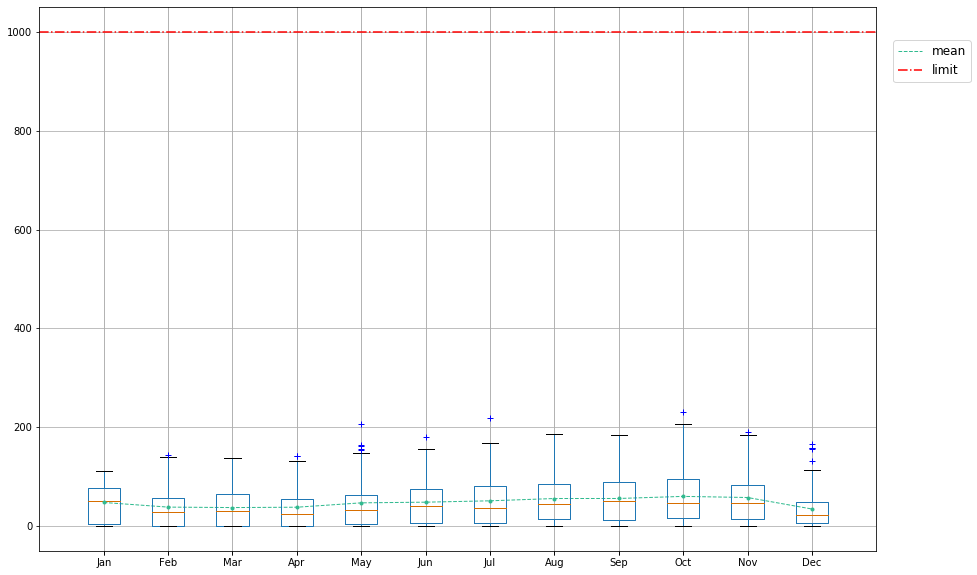

In [62]:
box_activ(users_messages, 'ultra', 'messages_included')

In [63]:
print ('Объём трафика')
mean_var_std(users_inet, 'ultra', 'mg_per_month_included').style.apply(color_column, col = 'per_month')

Объём трафика


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,9,24,37,55,67,84,91,107,114,120,133,135,81
sum,177723,466616,762788,1.16863e+06,1.44681e+06,1.75258e+06,1.96573e+06,2.25835e+06,2.20682e+06,2.59338e+06,2.75996e+06,1.61739e+06,30720
mean,19747,19442.3,20615.9,21247.9,21594.1,20864,21601.4,21106.1,19358.1,21611.5,20751.6,11980.7,1.59806e+06
var,8.25528e+07,7.73802e+07,9.65044e+07,8.5132e+07,8.5818e+07,8.14546e+07,1.06002e+08,8.07856e+07,8.07092e+07,1.0408e+08,1.02366e+08,8.15307e+07,6.8265e+11
std,9085.86,8796.6,9823.67,9226.7,9263.8,9025.22,10295.7,8988.08,8983.83,10202,10117.6,9029.43,826226


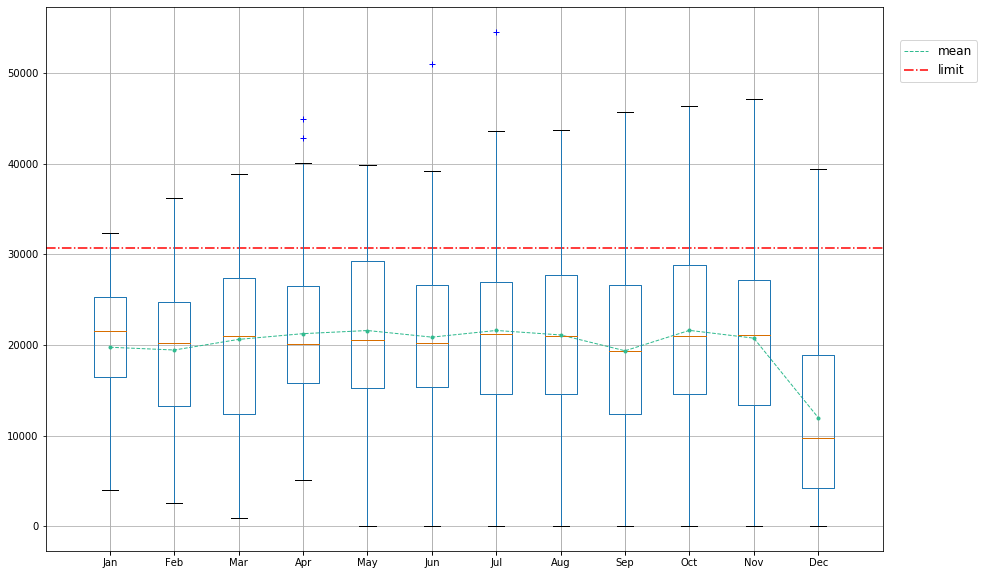

In [64]:
box_activ(users_inet, 'ultra', 'mg_per_month_included')

In [65]:
print ('Выручка')
mean_var_std(users_gain, 'ultra', 'rub_monthly_fee').style.apply(color_column, col = 'per_month')

Выручка


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,9,24,37,55,67,84,91,107,114,120,133,135,81
sum,17850,48600,77250,115500,139800,173250,196650,220350,228750,257700,281250,265650,1950
mean,1983.33,2025,2087.84,2100,2086.57,2062.5,2160.99,2059.35,2006.58,2147.5,2114.66,1967.78,168550
var,10000,46956.5,132973,216667,117771,164209,320989,107223,74226.2,239363,178249,18151.7,7.84286e+09
std,100,216.69,364.65,465.47,343.18,405.23,566.56,327.45,272.44,489.25,422.2,134.73,88560


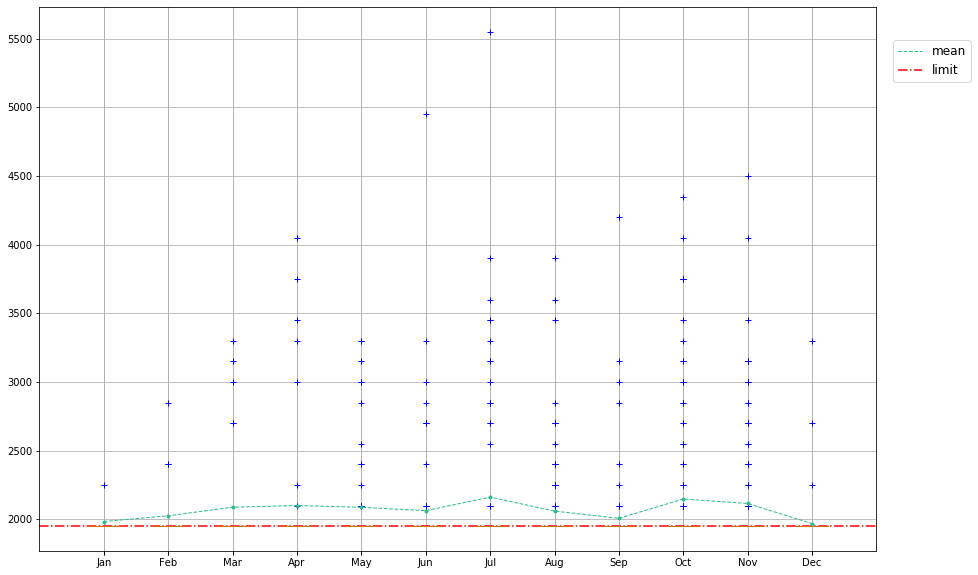

In [66]:
box_activ(users_gain, 'ultra', 'rub_monthly_fee')

<a id="smart"></a>
#### Тариф 'smart'

In [67]:
print ('Количество минут')
mean_var_std(users_calls_sum, 'smart', 'minutes_included').style.apply(color_column, col = 'per_month')

Количество минут


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,34,58,77,112,141,164,201,235,260,292,315,335,185
sum,14762,22172,34708,47183,62612,70287,91619,108070,113514,135824,145823,85003,500
mean,434.18,382.28,450.75,421.28,444.06,428.58,455.82,459.87,436.59,465.15,462.93,253.74,77631
var,34388.9,26474.3,30293.3,22530.5,27643.4,25810.1,28824.6,30694.5,31254.8,30734,38697.4,27886,1.87072e+09
std,185.44,162.71,174.05,150.1,166.26,160.66,169.78,175.2,176.79,175.31,196.72,166.99,43252


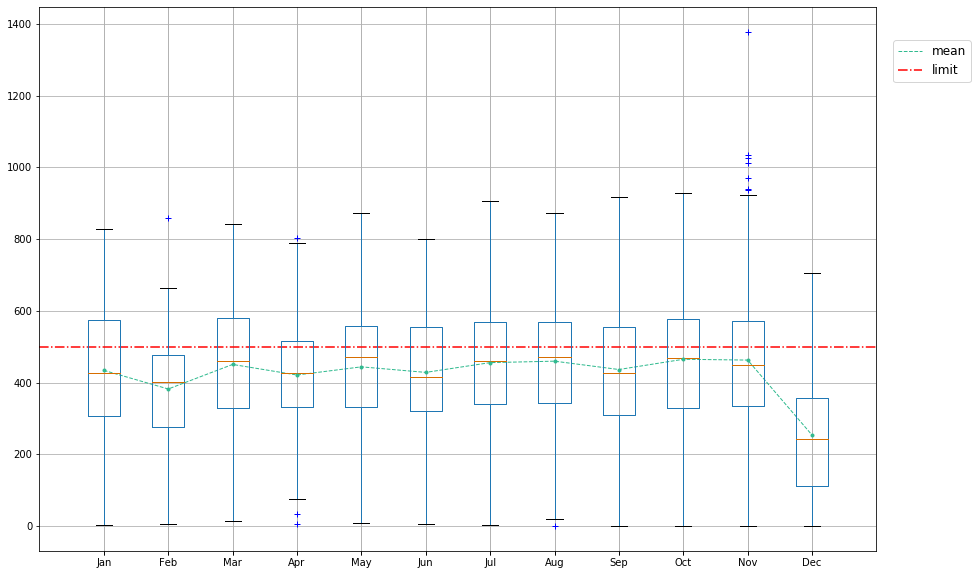

In [68]:
box_activ(users_calls_sum, 'smart', 'minutes_included')

In [69]:
print ('Количество сообщений')
mean_var_std(users_messages, 'smart', 'messages_included').style.apply(color_column, col = 'per_month')

Количество сообщений


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,34,58,77,112,141,164,201,235,260,292,315,335,185
sum,1258,1843,2787,4077,5295,5955,7276,8391,9136,10530,11081,6784,50
mean,37,31.78,36.19,36.4,37.55,36.31,36.2,35.71,35.14,36.06,35.18,20.25,6201
var,591.09,615.37,723.71,665.58,835.43,834.56,795.29,837.4,788.95,850.32,843.57,506.58,1.07213e+07
std,24.31,24.81,26.9,25.8,28.9,28.89,28.2,28.94,28.09,29.16,29.04,22.51,3274


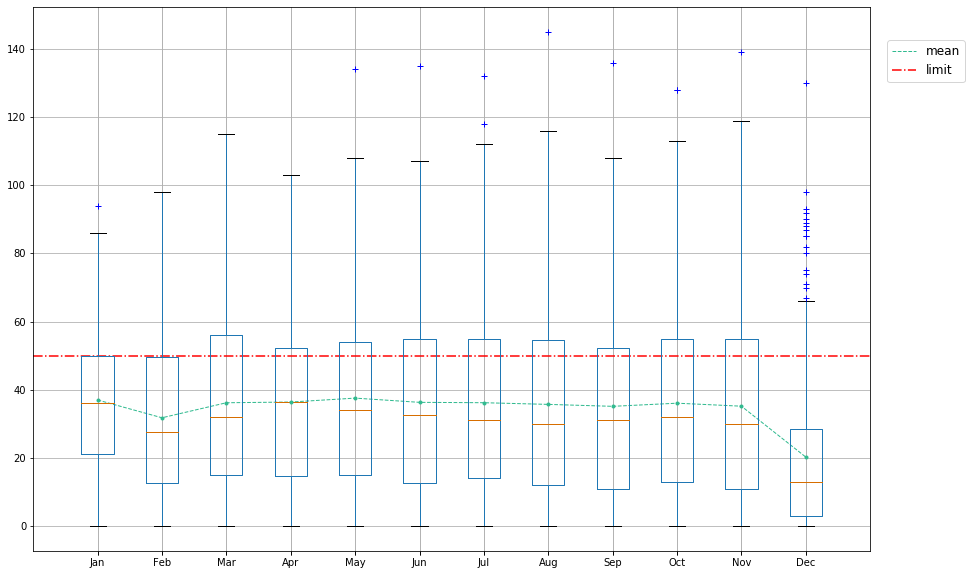

In [70]:
box_activ(users_messages, 'smart', 'messages_included')

In [71]:
print ('Объём трафика')
mean_var_std(users_inet, 'smart', 'mg_per_month_included').style.apply(color_column, col = 'per_month')

Объём трафика


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,34,58,77,112,141,164,201,235,260,292,315,335,185
sum,578125,884973,1.31008e+06,1.82136e+06,2.46555e+06,2.7913e+06,3.55473e+06,4.14263e+06,4.5171e+06,5.22358e+06,5.60921e+06,3.22985e+06,15360
mean,17003.7,15258.1,17014,16262.2,17486.2,17020.2,17685.2,17628.2,17373.5,17889,17807,9641.33,3.01071e+06
var,2.75831e+07,1.89434e+07,2.45945e+07,1.68248e+07,2.21577e+07,2.18306e+07,2.20899e+07,2.30008e+07,2.2728e+07,2.48282e+07,2.86418e+07,3.35889e+07,2.7847e+12
std,5251.97,4352.4,4959.28,4101.81,4707.19,4672.32,4699.99,4795.91,4767.39,4982.8,5351.8,5795.59,1.66874e+06


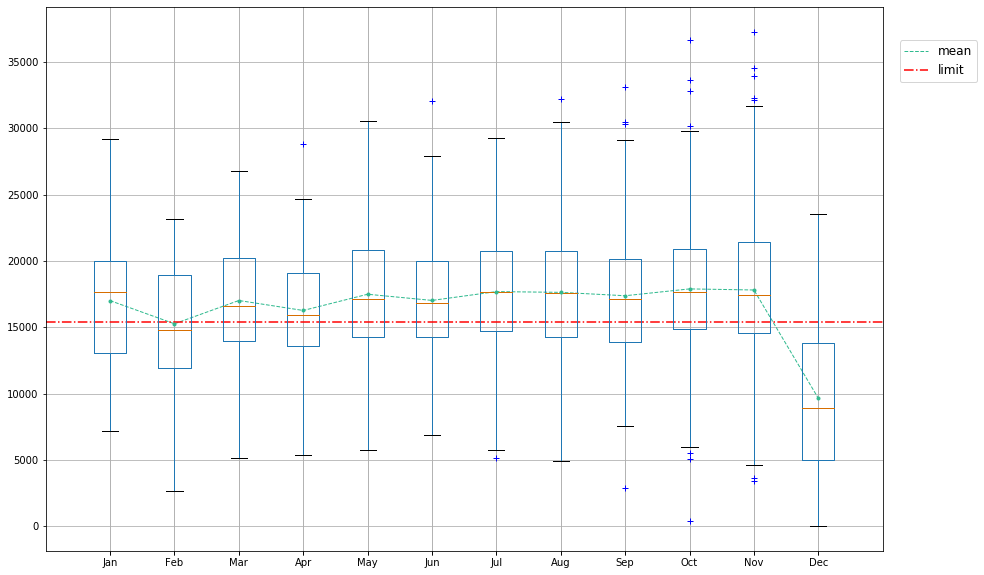

In [72]:
box_activ(users_inet, 'smart', 'mg_per_month_included')

In [73]:
print ('Выручка')
mean_var_std(users_gain, 'smart', 'rub_monthly_fee').style.apply(color_column, col = 'per_month')

Выручка


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,per_month
users,34,58,77,112,141,164,201,235,260,292,315,335,185
sum,46541,58310,104419,125178,192060,222414,286915,347150,367612,469081,562572,240387,550
mean,1368.85,1005.34,1356.09,1117.66,1362.13,1356.18,1427.44,1477.23,1413.89,1606.44,1785.94,717.57,251887
var,680969,284223,503223,370300,607237,1.45394e+06,663351,1.22697e+06,1.30064e+06,2.87523e+06,5.13958e+06,155763,2.63104e+10
std,825.21,533.13,709.38,608.52,779.25,1205.79,814.46,1107.69,1140.45,1695.65,2267.06,394.67,162205


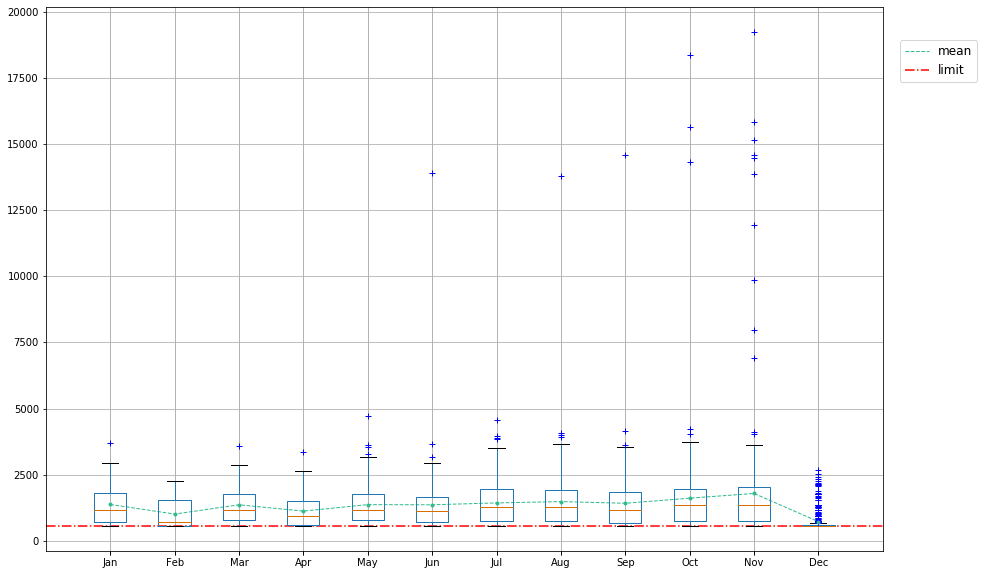

In [74]:
box_activ(users_gain, 'smart', 'rub_monthly_fee')

<a id="histograms"></a>
### Гистограммы распределения

In [75]:
def sephist(df, col):
    smart = df[df['tariff'] == 'smart'][col]
    ultra = df[df['tariff'] == 'ultra'][col]
    return smart, ultra

cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def hist_month(df):
    fig, axes = plt.subplots(4, 3, figsize = (15, 10))
    for num, alpha in enumerate(cols):
        plt.subplot(4, 3, num + 1)
        with np.errstate(invalid = 'ignore'):
            plt.hist(sephist(df, alpha)[0], bins = 25, alpha = 0.5, label = 'smart', color = 'b')
            plt.hist(sephist(df, alpha)[1], bins = 25, alpha = 0.5, label = 'ultra', color = 'r')
        if num == 2:
            plt.legend(loc = 'upper right')
        plt.title(alpha)

    plt.tight_layout(pad = 0.4, w_pad = 0.6)
    plt.show()

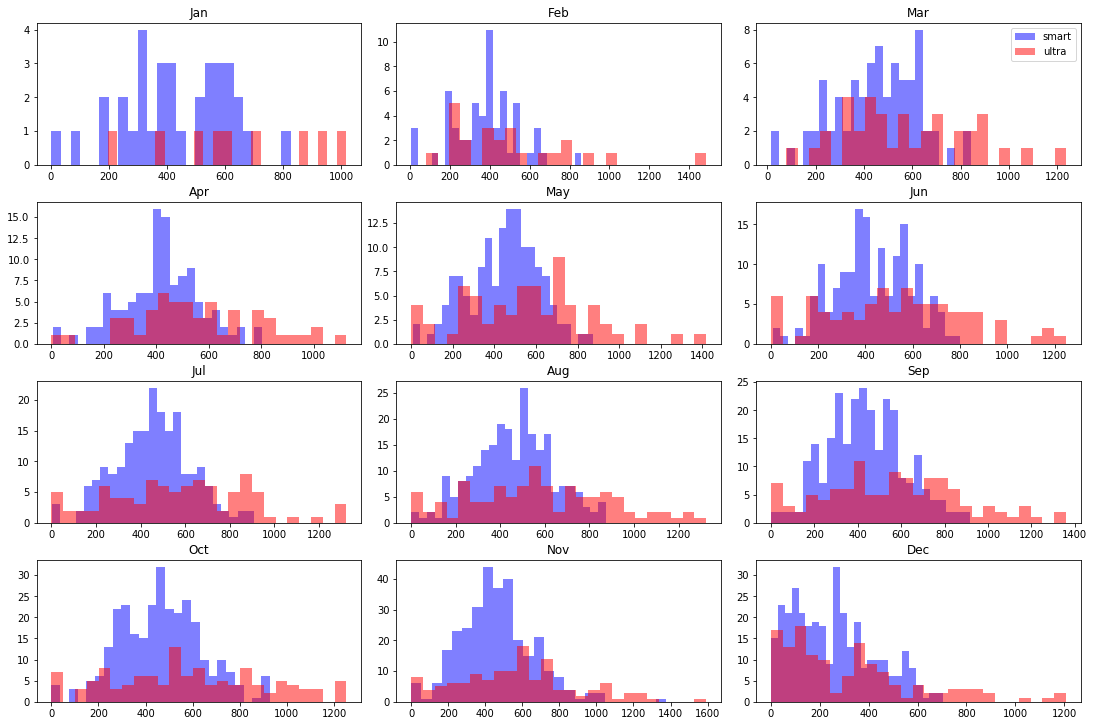

In [76]:
hist_month(users_calls_sum)

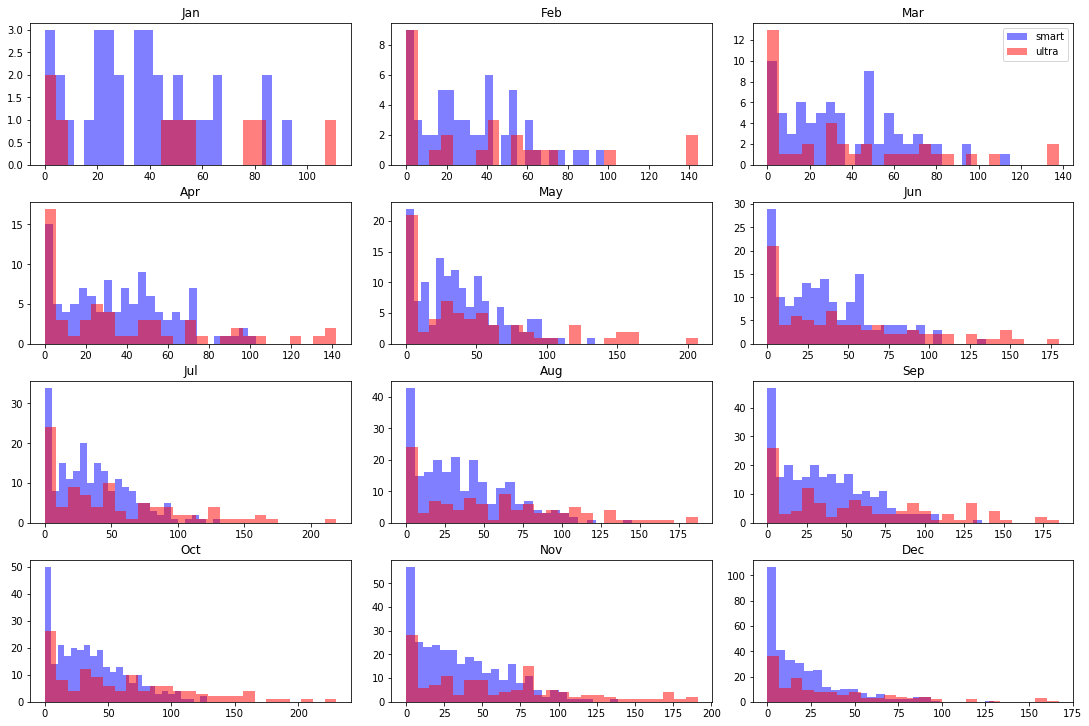

In [77]:
hist_month(users_messages)

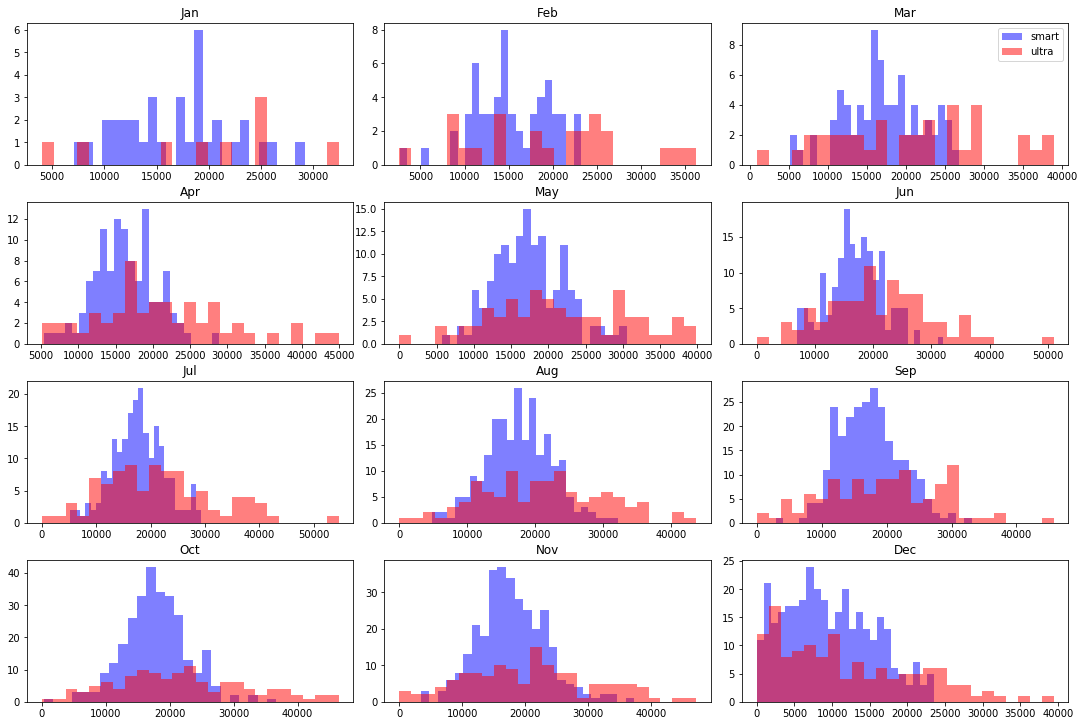

In [78]:
hist_month(users_inet)

Пользователей тарифа *'ultra'* достаточно мало, но видно, что в целом количество минут и сообщений и объём интернет-трафика имеют нормальные распределения.  
В январе было подключено слишком мало пользователей, чтобы наглядно увидеть распределение.  
Декабрь оказался неполным из-за выгрузки данных, поэтому набор данных по декабрю скошен вправо.

<a id="hypothesis"></a>
## **Гипотезы**

Для обеих гипотез сравниваются независимые совокупности данных, поэтому был выбран критерий для сравнения независимых совокупностей.

In [79]:
def print_gain(tariff_name):
    limit = tariffs.query('tariff_name == @tariff_name')['rub_monthly_fee'].mean()
    print ('Выручка с тарифа '+str(tariff_name)+': {:.0f}'.format(users_gain
                                                             .query('tariff == @tariff_name')
                                                             .loc[:, 'Jan':'Dec'].sum().sum()))
    print ('Выручка со всех пользователей по абонентской плате: {:.0f}'.format(
           (users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].count() * limit).sum()))
    print ('Выручка со всех пользователей сверх абонентской платы: {:.0f}'.format(
           (users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].sum() -
            users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].count() * limit).sum()))
    print ('Доля выручки со всех пользователей сверх абонентской платы: {:.2%}'.format(
           ((users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].sum() -
            users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].count() * limit).sum()) /
            users_gain.query('tariff == @tariff_name').loc[:, 'Jan':'Dec'].sum().sum()))
    print ('Количество пользователей:', len(users.query('tariff == @tariff_name')['user_id'].unique()))
    print ('Доля пользователей, которые укладываются в пределы тарифа: {:.2%}'
           .format(len(users_gain.query('tariff == @tariff_name and mean_price == @limit')['user_id'].unique()) /
                   len(users.query('tariff == @tariff_name')['user_id'].unique())) )

In [80]:
def over_limit(df, tariff, activ_col):
    temp_data = pd.DataFrame()
    temp_data = df.query('tariff == @@tariff').copy()
    for month in cols:
        temp_data[month] = (
            temp_data[temp_data[month].notna()][month]
            .where((temp_data[month] >= tariffs.query('tariff_name == @@tariff')[activ_col].mean()), 0)
        )
        temp_data[month] = (
            temp_data[temp_data[month].notna()][month]
            .where((temp_data[month] < tariffs.query('tariff_name == @@tariff')[activ_col].mean()),
                   temp_data[month] - tariffs.query('tariff_name == @@tariff')[activ_col].mean())
        )
    del temp_data['reg_date']
    del temp_data['churn_date']
    del temp_data['month']
    return temp_data

In [81]:
def plot_gain(tariff):
    # абонентская плата
    gain_limit = (
        users_gain.query('tariff == @@tariff').loc[:, 'Jan':'Dec'].count() *
        tariffs.query('tariff_name == @@tariff')['rub_monthly_fee'].mean()
    )

    # выручка за минуты сверх тарифа
    per_minute = (
        over_limit(calls_user_sum, tariff, 'minutes_included').loc[:, 'Jan':'Dec'].sum() *
        tariffs.query('tariff_name == @@tariff')['rub_per_minute'].mean()
    )

    # выручка за сообщения сверх тарифа
    per_messages = (
        over_limit(messages_users_num, tariff, 'messages_included').loc[:, 'Jan':'Dec'].sum() *
        tariffs.query('tariff_name == @@tariff')['rub_per_minute'].mean()
    )

    # выручка за гигабайты сверх тарифа
    mg = over_limit(internet_users, tariff, 'mg_per_month_included')
    for month in cols:
        mg[month] = (
            mg[mg[month].notna()][month]
            .where((mg[month] == 0), np.ceil(mg[month] / 1024))
        )
    per_gb = (
        mg.loc[:, 'Jan':'Dec'].sum() *
        tariffs.query('tariff_name == @@tariff')['rub_per_gb'].mean()
    )

    gain = pd.DataFrame()
    for x in cols:
        gain.loc['gain_limit', x] = gain_limit[x]
        gain.loc['per_minute', x] = per_minute[x]
        gain.loc['per_messages', x] = per_messages[x]
        gain.loc['per_gb', x] = per_gb[x]

    gain.T.plot(kind = 'bar', grid = True, figsize = (15, 5), legend = True, stacked = True,
               title = str(tariff))
    plt.savefig('images/'+str(tariff)+'_gain.png')
    return plt.show()

In [82]:
def pval(one, two):
    alpha = 0.05

    results = st.ttest_ind(one, two)

    print('p-значение:', results.pvalue)
    print('вероятность: {:.2%}'.format(results.pvalue))

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

$H_0$ = "средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается"

In [83]:
smart = users_gain.query('tariff == "smart"').loc[:, 'Jan':'Dec'].mean()
ultra = users_gain.query('tariff == "ultra"').loc[:, 'Jan':'Dec'].mean()

pval(smart, ultra)

p-значение: 9.258916049834593e-09
вероятность: 0.00%
Отвергаем нулевую гипотезу


In [84]:
print_gain('smart')

Выручка с тарифа smart: 3022639
Выручка со всех пользователей по абонентской плате: 1223200
Выручка со всех пользователей сверх абонентской платы: 1799439
Доля выручки со всех пользователей сверх абонентской платы: 59.53%
Количество пользователей: 351
Доля пользователей, которые укладываются в пределы тарифа: 4.27%


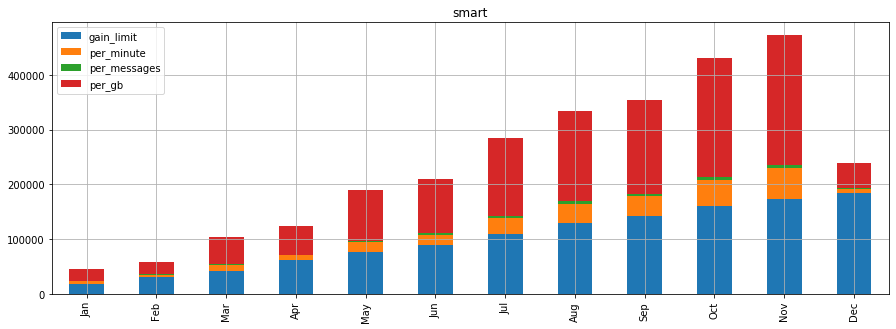

In [85]:
plot_gain('smart')

In [86]:
print_gain('ultra')

Выручка с тарифа ultra: 2022600
Выручка со всех пользователей по абонентской плате: 1903200
Выручка со всех пользователей сверх абонентской платы: 119400
Доля выручки со всех пользователей сверх абонентской платы: 5.90%
Количество пользователей: 149
Доля пользователей, которые укладываются в пределы тарифа: 71.14%


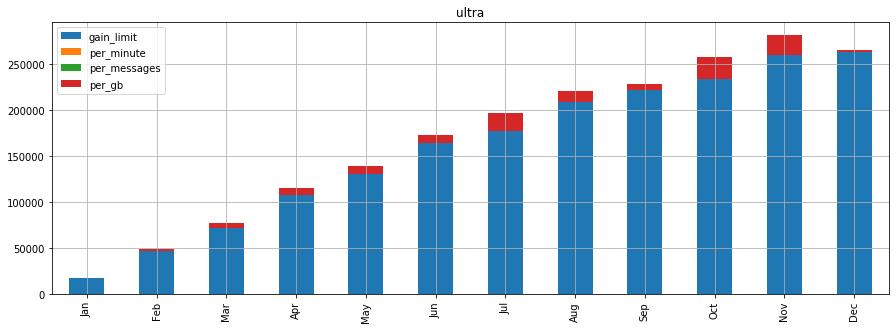

In [87]:
plot_gain('ultra')

С увеличением количества пользователей растёт и выручка, но значительную часть выручки пользователей тарифа "Smart" приносят доплаты за превышение лимита интернет-трафика, в то время как пользователи тарифа "Ultra" практически не выходят за пределы лимитов.

Тариф "Smart" приносит большую выручку, чем тариф "Ultra"

$H_0$ = "средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов"

In [88]:
users_gain_city = pd.merge(users_gain, users[['user_id', 'city']], on = 'user_id', how = 'outer')
moscow = users_gain_city.query('city == "Москва"').loc[:, 'Jan':'Dec'].mean()
not_moscow = users_gain_city.query('city != "Москва"').loc[:, 'Jan':'Dec'].mean()
pval(moscow, not_moscow)

p-значение: 0.780640313375203
вероятность: 78.06%
Не получилось отвергнуть нулевую гипотезу


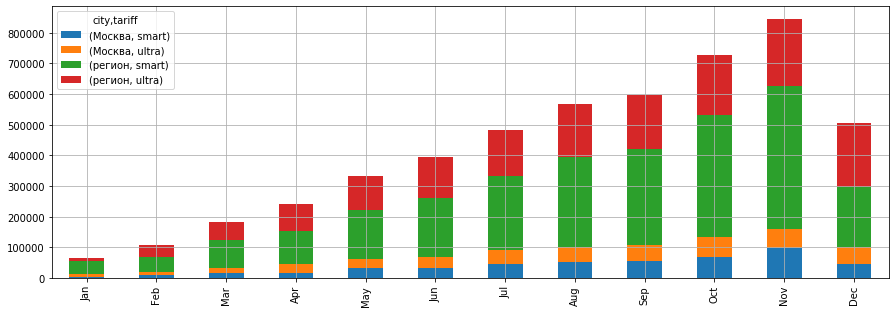

In [89]:
gain_city = pd.DataFrame()
gain_city = users_gain_city.copy()
gain_city['city'] = (
    gain_city['city']
    .where(gain_city['city'] == 'Москва', 'регион')
)
del gain_city['reg_date']
del gain_city['churn_date']
del gain_city['mean_price']
del gain_city['user_id']

gain_city.groupby(['city', 'tariff']).sum().T.plot(kind = 'bar', grid = True, figsize = (15, 5), legend = True, stacked = True)

plt.savefig('images/city_gain.png')
plt.show()

Пользователи, живущие в регионах, приносят большую выручку, чем пользователи Москвы.  
Большую часть выручки с регионов приносят пользователи тарифа "Smart".

<a id="summary"></a>
# **Выводы**

1. Было обнаружено много звонков нулевой длительности и интернет-сессий с нулевым трафиком.
    - Звонки нулевой длительности скорее всего означают, что абонент не дозвонился
    - Интернет-сессии с нулевым трафиком скорее всего возникали, когда человек был подключён к интернету, но ни один пакет данных не передал
    ![](images/zero.png)
   
2. В среднем каждый пользователь, который пользовался услугой, в месяц тратил

услуга|общее|smart|ultra
-|-|-|-
количество звонков|64.34|59.14|77.01
количество минут|461.11|423.24|553.54
количество сообщений|45.69|37.71|65.11
объём интрнет-трафика (Mb)|17355.29|16252.89|19980.05
оплата|1644.46|1456.33|2089.37

3. Статистические данные.
    Тариф "Smart":
    В среднем в месяц было потрачено
    - 77631 минут
        - с дисперсией 1870.72e+6
        - и стандартным отклонением 43252
    - 6201 сообщений
        - с дисперсией 10721300
        - и стандартным отклонением 3274
    - 3010710 Mb трафика
        - с дисперсией 2.7847e+12
        - и стандартным отклонением 1668740
    - 251887 рублей
        - с дисперсией 2.63104e+10
        - и стандартным отклонением 162205
    Тариф "Ultra":
    В среднем в месяц было потрачено
    - 43227 минут
        - с дисперсией 513319000
        - и стандартным отклонением 22657
    - 4052 сообщений
        - с дисперсией 6152330
        - и стандартным отклонением 2480
    - 30720 Mb трафика
        - с дисперсией 1598060
        - и стандартным отклонением 826226
    - 168550 рублей
        - с дисперсией 7842.86e+6
        - и стандартным отклонением 88560
        
Тариф|smart|ultra
:---------:|:------------:|:-------------:
Количество минут|![](images/smart_minutes_included.png)|![](images/ultra_minutes_included.png)
Количество сообщений|![](images/smart_messages_included.png)|![](images/ultra_messages_included.png)
Объём трафика|![](images/smart_mg_per_month_included.png)|![](images/ultra_mg_per_month_included.png)
Выручка|![](images/smart_rub_monthly_fee.png)|![](images/ultra_rub_monthly_fee.png)

Пользователям тарифа *'ultra'* можно предлагать 800 минут, 80 сообщений и 28 Gb в месяц, снизив стоимость абонентской платы, тогда они всё равно скорее всего останутся на этом тарифе, но будут приносить больший доход за счёт доплаты за лишние минуты, сообщения и трафик. А более низкая стоимость абонентской платы с такими параметарами привлечёт и пользователей тарифа smart, которые доплачивают за лишние минуты, сообщения и трафик на своём тарифе.

4. Гипотезы  
    Для обеих гипотез сравниваются независимые совокупности данных, поэтому был выбран критерий для сравнения независимых совокупностей.  
    - Было предположено, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
        Предположение не оправдалось. Тариф "Smart" приносит большую выручку, чем тариф "Ultra".  
    ![](images/smart_gain.png)
    ![](images/ultra_gain.png)

   - Также, было предположено, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
    Предположение опровергнуть не удалось.  
![](images/city_gain.png)